**1. Импортируем необходимые библиотеки.**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kurtosis
from scipy.stats import skew
from scipy import stats

%matplotlib inline
plt.rcParams["figure.figsize"] = (10.0, 7.0)

**2. Загружаем CSV-файлы, валидируем данные.**

In [3]:
# загружает таблицу групп юзеров АВ-теста
df_AB_group = pd.read_csv('ABgroup.csv')

In [4]:
df_AB_group.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8640000 entries, 0 to 8639999
Data columns (total 2 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   user_id  object
 1   group    object
dtypes: object(2)
memory usage: 131.8+ MB


In [5]:
# оставляем только уникальных юзеров
df_AB_group = df_AB_group.drop_duplicates()

In [6]:
# загружаем таблицу внутриигровой валюты
df_cash = pd.read_csv('Cash.csv', parse_dates=['date'], dayfirst=True)

In [7]:
df_cash.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8640000 entries, 0 to 8639999
Data columns (total 3 columns):
 #   Column   Dtype         
---  ------   -----         
 0   user_id  object        
 1   date     datetime64[ns]
 2   cash     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 197.8+ MB


In [8]:
# загружаем таблицу читеров
df_cheaters = pd.read_csv('Cheaters.csv')

In [9]:
df_cheaters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8640000 entries, 0 to 8639999
Data columns (total 2 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   user_id   object
 1   cheaters  int64 
dtypes: int64(1), object(1)
memory usage: 131.8+ MB


In [10]:
# оставляем только уникальных юзеров
df_cheaters = df_cheaters.drop_duplicates()

In [11]:
# загружаем таблицу выручки, валидируя дату, так как изначально дата в формате object
df_money = pd.read_csv('Money.csv', parse_dates=['date'], dayfirst=True)

In [12]:
df_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8640000 entries, 0 to 8639999
Data columns (total 3 columns):
 #   Column   Dtype         
---  ------   -----         
 0   user_id  object        
 1   date     datetime64[ns]
 2   money    float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 197.8+ MB


In [13]:
# загружаем таблицу платформ
df_platforms = pd.read_csv('Platforms.csv')

In [14]:
df_platforms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8640000 entries, 0 to 8639999
Data columns (total 2 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   user_id   object
 1   platform  object
dtypes: object(2)
memory usage: 131.8+ MB


In [15]:
# оставляем только данные по уникальным юзерам
df_platforms = df_platforms.drop_duplicates()

**3.  Сводим все таблицы в один датафрейм для последующего анализа.**

In [16]:
# склейка всех таблиц в одну по столбцу user_id
df_total = df_money.merge(df_cheaters, on=['user_id'], how='left')

In [17]:
df_total = df_total.merge(df_platforms, on=['user_id'], how='left')

In [18]:
df_total = df_total.merge(df_cash, on=['user_id', 'date'], how='outer')

In [19]:
df_total = df_total.merge(df_AB_group, on=['user_id'], how='left')

In [20]:
df_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8640000 entries, 0 to 8639999
Data columns (total 7 columns):
 #   Column    Dtype         
---  ------    -----         
 0   user_id   object        
 1   date      datetime64[ns]
 2   money     float64       
 3   cheaters  int64         
 4   platform  object        
 5   cash      int64         
 6   group     object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 527.3+ MB


In [21]:
# проверяем наличие дубликатов. 
df_total.drop_duplicates()
# количество строк совпадает, приходим к выводу, что дублей нет

,user_id,date,money,cheaters,platform,cash,group
0,N4TS2T-P7YTVX,2021-07-15,1.99,0,PS4,1150,test
1,NX9S0D-VM20W8,2021-07-16,0.99,0,XBox,1500,test
2,QYY6FW-FKHRND,2021-07-15,0.00,0,XBox,200,control
3,BRWH4Y-LPGBU6,2021-07-14,0.00,0,PC,300,test
4,8O317F-4ASK53,2021-07-13,0.00,0,PC,900,control
...,...,...,...,...,...,...,...
8639995,V2QN9A-KTAB7P,2021-07-15,0.00,0,PC,850,test
8639996,UH5OG7-7KLM76,2021-07-14,0.99,0,PC,400,control
8639997,6O1AE8-8AEE55,2021-07-17,0.99,0,XBox,0,control
8639998,33AD2T-TNRERG,2021-07-12,0.99,0,PC,1000,test


**4. Ищем дополнительных читеров.**

In [22]:
# анализируем профиль известных читеров для выявление новых.
df_only_cheaters = df_total[df_total['cheaters'] == 1].groupby('user_id', as_index=False).sum()

In [23]:
df_only_cheaters.describe()

,money,cheaters,cash
count,353.0,353.0,353.000000
mean,0.0,8.0,146807.932011
std,0.0,0.0,33800.925081
min,0.0,8.0,46700.000000
25%,0.0,8.0,125100.000000
50%,0.0,8.0,147200.000000
75%,0.0,8.0,169700.000000
max,0.0,8.0,253150.000000


In [24]:
# чистим общую таблицу от известных читеров
df_total_without_cheaters = df_total[df_total['cheaters'] == 0].groupby('user_id', as_index=False).sum()

D:\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='cash', ylabel='Density'>

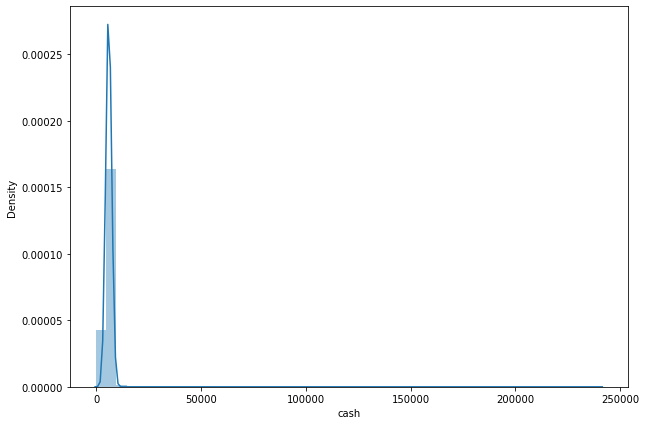

In [26]:
# построив график распределения cash без известных читеров, увидели огромный хвост до почти 250000. 
# судя по графику после чистки известных читеров, все равно остались игроки с "зашкальными" тратами внутриигровой валюты.
sns.distplot(df_total_without_cheaters['cash'])

In [27]:
# находим значение 99 % таблицы cash без известных читеров
p_99 = np.percentile(df_total_without_cheaters['cash'], 99)
# находим значение upper_level 3 sigm cash без известных читеров
upper_level = df_total_without_cheaters['cash'].mean() + 3*df_total_without_cheaters['cash'].std()

D:\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='cash', ylabel='Density'>

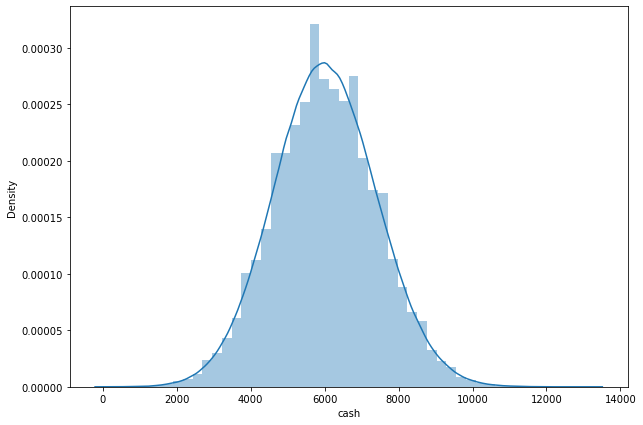

In [28]:
# строим график без известных читеров, после отрезания правого хвоста.
# график распределения стал визуально близким к нормальному

sns.distplot(df_total_without_cheaters[df_total_without_cheaters['cash'] < max(p_99, upper_level)]['cash'])

In [29]:
# создаем ДФ всех найденных читеров, для возможного дополнительного анализа, проверки и подобное.
# присваем читерам флаг 1 и оставляем только колонки user_id и cheaters_flag. 
df_add_cheaters = df_total_without_cheaters[df_total_without_cheaters['cash'] >= max(p_99, upper_level)]

In [30]:
# анализируем профиль найденных читеров, смотрим, что найденные читеры не донаторы.
# по итогу выявлено новых 344 читера.
df_add_cheaters.describe()

,money,cheaters,cash
count,344.0,344.0,344.000000
mean,0.0,0.0,150992.005814
std,0.0,0.0,34665.308127
min,0.0,0.0,20700.000000
25%,0.0,0.0,124450.000000
50%,0.0,0.0,150125.000000
75%,0.0,0.0,175837.500000
max,0.0,0.0,240950.000000


In [31]:
# создаем копию ДФ новых читеров с флагом читера, чтобы не затирать ДФ выявленных читеров для дальнейшего использования:
# построение дашбордов, доп.анализа и др. 
df_add_cheaters_copy = df_add_cheaters.copy()
df_add_cheaters_copy['cheaters_add'] = 1
df_add_cheaters_copy = df_add_cheaters_copy[['user_id', 'cheaters_add']]

In [32]:
# проставляем флаг новых читеров в основном ДФ.
df_total = df_total.merge(df_add_cheaters_copy, on = 'user_id', how = 'left')
df_total.fillna(0, inplace = True)

In [33]:
df_total.head()

,user_id,date,money,cheaters,platform,cash,group,cheaters_add
0,N4TS2T-P7YTVX,2021-07-15,1.99,0,PS4,1150,test,0.0
1,NX9S0D-VM20W8,2021-07-16,0.99,0,XBox,1500,test,0.0
2,QYY6FW-FKHRND,2021-07-15,0.00,0,XBox,200,control,0.0
3,BRWH4Y-LPGBU6,2021-07-14,0.00,0,PC,300,test,0.0
4,8O317F-4ASK53,2021-07-13,0.00,0,PC,900,control,0.0


**5. Считаем основные метрики по группам и платформам.**

In [34]:
# расчет ARPU для разных платформ и групп
df_arpu = df_total[(df_total['cheaters'] == 0) & 
                   (df_total['cheaters_add'] == 0)].groupby(['platform', 'group'], as_index=False).agg(
    sum_money = pd.NamedAgg(column='money', aggfunc='sum'),
    users_q = pd.NamedAgg(column='user_id', aggfunc='nunique'))

df_arpu['arpu'] = df_arpu['sum_money']/df_arpu['users_q']

In [35]:
df_arpu

,platform,group,sum_money,users_q,arpu
0,PC,control,1014803.06,179732,5.646201
1,PC,test,1127299.88,179820,6.269046
2,PS4,control,1031651.87,179804,5.737647
3,PS4,test,1091719.21,179415,6.084883
4,XBox,control,1101410.86,180455,6.103521
5,XBox,test,1104370.09,180077,6.132766


In [36]:
# расчет ARPPU для разных платформ и групп.
# исключая записи с платежами равными 0, мы не исключаем пользователя, а только конкретные записи с нулевыми платежами.
df_arppu = df_total[(df_total['money'] != 0) & 
                   (df_total['cheaters'] == 0) & 
                    (df_total['cheaters_add'] == 0)].groupby(['platform', 'group'], as_index=False).agg(
    sum_money = pd.NamedAgg(column='money', aggfunc='sum'),
    pay_user = pd.NamedAgg(column='user_id', aggfunc='nunique'))

df_arppu['arppu'] = df_arppu['sum_money']/df_arppu['pay_user']

In [37]:
df_arppu

,platform,group,sum_money,pay_user,arppu
0,PC,control,1014803.06,179665,5.648307
1,PC,test,1127299.88,179800,6.269743
2,PS4,control,1031651.87,179747,5.739466
3,PS4,test,1091719.21,179386,6.085866
4,XBox,control,1101410.86,180428,6.104434
5,XBox,test,1104370.09,180050,6.133686


In [162]:
# расчет трат внутриигровой валюты для разных платформ и групп
df_spend_cash = df_total[(df_total['cheaters'] == 0) & 
                    (df_total['cheaters_add'] == 0)].groupby(['platform', 'group'], as_index=False).agg(
    spend_cash = pd.NamedAgg(column='cash', aggfunc='sum'),
    users_q = pd.NamedAgg(column='user_id', aggfunc='nunique'))

df_spend_cash['cash_per_user'] = (df_spend_cash['spend_cash']/df_spend_cash['users_q']).round(2)

In [163]:
df_spend_cash

,platform,group,spend_cash,users_q,cash_per_user
0,PC,control,1004181050,179732,5587.10
1,PC,test,1147565500,179820,6381.75
2,PS4,control,1021634850,179804,5681.94
3,PS4,test,1099902450,179415,6130.49
4,XBox,control,1106512800,180455,6131.79
5,XBox,test,1112228100,180077,6176.40


**6. Метрики по дням**

In [164]:
# расчет ARPDAU для разных платформ и групп по дням
df_arpdau = df_total[(df_total['cheaters'] == 0) & (df_total['cheaters_add'] == 0)].groupby(['platform', 'group', 'date'], as_index=False).agg(
    sum_money = pd.NamedAgg(column='money', aggfunc='sum'),
    users_q = pd.NamedAgg(column='user_id', aggfunc='nunique'))

df_arpdau['arpdau'] = df_arpdau['sum_money']/df_arpdau['users_q']
#df_arpdau.set_index('date', inplace=True)

In [167]:
df_arpdau.head()

,platform,group,date,sum_money,users_q,arpdau
0,PC,control,2021-07-10,128800.06,179732,0.716623
1,PC,control,2021-07-11,128127.62,179732,0.712882
2,PC,control,2021-07-12,128008.34,179732,0.712218
3,PC,control,2021-07-13,125276.96,179732,0.697021
4,PC,control,2021-07-14,118642.02,179732,0.660105


In [42]:
# сохраняем сводную таблицу ARPDAU в EXCEL
df_arpdau.to_excel("arpu_daily.xlsx", sheet_name='arpu')

In [168]:
# расчет ARPPDAU для разных платформ и групп
df_arppdau = df_total[(df_total['money'] != 0) & 
                   (df_total['cheaters'] == 0) & 
                    (df_total['cheaters_add'] == 0)].groupby(['platform', 'group', 'date'], as_index=False).agg(
    sum_money = pd.NamedAgg(column='money', aggfunc='sum'),
    pay_user = pd.NamedAgg(column='user_id', aggfunc='nunique'))

df_arppdau['arppdau'] = df_arppdau['sum_money']/df_arppdau['pay_user']

In [244]:
# сохраняем сводную таблицу ARPPDAU в EXCEL
df_arppdau.to_excel("ARPPDAU.xlsx", sheet_name='arppdau')

In [172]:
df_arppdau.head(8)

,platform,group,date,sum_money,pay_user,arppdau
0,PC,control,2021-07-10,128800.06,106594,1.208324
1,PC,control,2021-07-11,128127.62,106138,1.207180
2,PC,control,2021-07-12,128008.34,105966,1.208013
3,PC,control,2021-07-13,125276.96,104204,1.202228
4,PC,control,2021-07-14,118642.02,99898,1.187632
5,PC,control,2021-07-15,108756.68,93032,1.169024
6,PC,control,2021-07-16,96911.24,85176,1.137776
7,PC,control,2021-07-17,180280.14,103786,1.737037


In [45]:
# расчет трат внутриигровой валюты для разных платформ и групп по дням
df_spend_cash_daily = df_total[(df_total['cheaters'] == 0) & 
                    (df_total['cheaters_add'] == 0)].groupby(['platform', 'group', 'date'], as_index=False).agg(
    spend_cash = pd.NamedAgg(column='cash', aggfunc='sum'),
    users_q = pd.NamedAgg(column='user_id', aggfunc='nunique'))

df_spend_cash_daily['cash_day'] = (df_spend_cash_daily['spend_cash']/df_spend_cash_daily['users_q']).round(2)

In [175]:
df_spend_cash_daily.head(8)

,platform,group,date,spend_cash,users_q,cash_day
0,PC,control,2021-07-10,134715050,179732,749.53
1,PC,control,2021-07-11,134582300,179732,748.79
2,PC,control,2021-07-12,133968700,179732,745.38
3,PC,control,2021-07-13,130591150,179732,726.59
4,PC,control,2021-07-14,122138400,179732,679.56
5,PC,control,2021-07-15,106732200,179732,593.84
6,PC,control,2021-07-16,85926500,179732,478.08
7,PC,control,2021-07-17,155526750,179732,865.33


In [248]:
# создаем общий ДФ дневных метрик:
df_daily_metrics = df_arpu_daily.merge(df_spend_cash_daily, on=['platform', 'group', 'date'], how='left')

In [250]:
df_daily_metrics = df_daily_metrics.merge(df_arppdau, on=['platform', 'group', 'date'], how='left')

In [255]:
df_daily_metrics = df_daily_metrics[['platform', 'group', 'date', 'arpu_daily', 'arppdau', 'cash_day', 'sum_money_x']]

In [256]:
# сохраняем сводную таблицу  дневных метрик в EXCEL для PowerBI
df_daily_metrics.to_excel("df_daily_metrics.xlsx", sheet_name='metrics_day')

**7. Построение доверительных интервалов средних значений RPU по платформам и группам**

In [305]:
# создаем функцию для построения графиков доверительных интервалов: 
def norm_confidence_plot(df, column, alpha, platform):
   
    df_test=df[(df['platform'] == platform) & (df['group'] == 'test')]
    interval_test = stats.norm.interval(alpha, loc=df_test[column].mean(), scale=df_test[column].std())

    df_control=df[(df['platform'] == platform) & (df['group'] == 'control')]
    interval_control = stats.norm.interval(alpha, loc=df_control[column].mean(), scale=df_control[column].std())
            
    test_label = f'Нижняя граница ТГ ({round(interval_test[0], 2)})'
    control_label = f'Нижняя граница КГ ({round(interval_control[0], 2)})'
    test_label_1 = f'Верхняя граница ТГ ({round(interval_test[1],2)})'
    control_label_1 = f'Верхняя граница КГ ({round(interval_control[1],2)})'
    
    plt.figure(figsize=(16, 9))
    
    df_test[column].hist(bins = 30, alpha = 0.7, color="r")
    df_control[column].hist(bins = 30, alpha = 0.8) 
    
    plt.axvline(x=interval_test[0], color="g", linestyle="--", linewidth = 3, label=test_label)
    plt.axvline(x=interval_test[1], color="g", linestyle="-", linewidth = 3, label=test_label_1)
    plt.axvline(x=interval_control[0], color="r", linestyle="--", linewidth = 3, label=control_label)
    plt.axvline(x=interval_control[1], color="r", linestyle="-", linewidth = 3, label=control_label_1)
    
    plt.title(f'Доверительные интервалы 95% для {column} платформы {platform}', fontsize=18)
    plt.legend([test_label, test_label_1, control_label, control_label_1,
                'Тестовая группа', 'Контрольная группа'], 
               loc='right', bbox_to_anchor=(1, 0.8), fontsize = 'large')


**7.1. Доверительные интервалы ARPU для платформы PC**

In [306]:
# создаем ДФ ARPU каждого юзера без учета читеров для проверки статзначимости А/В теста.
df_arpu_user = df_total[(df_total['cheaters'] == 0) & 
                                    (df_total['cheaters_add'] == 0)].groupby(['user_id','platform','group'], as_index = False).agg(
    user_arpu = pd.NamedAgg(column='money', aggfunc='sum'))

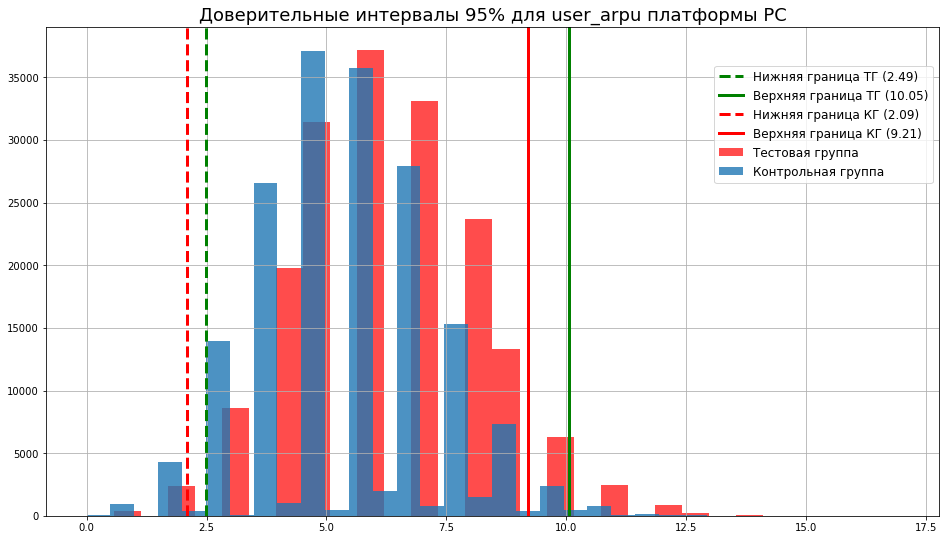

In [307]:
norm_confidence_plot(df_arpu_user,'user_arpu', 0.95, 'PC')

**7.2. Доверительные интервалы ARPU для платформы PS4**

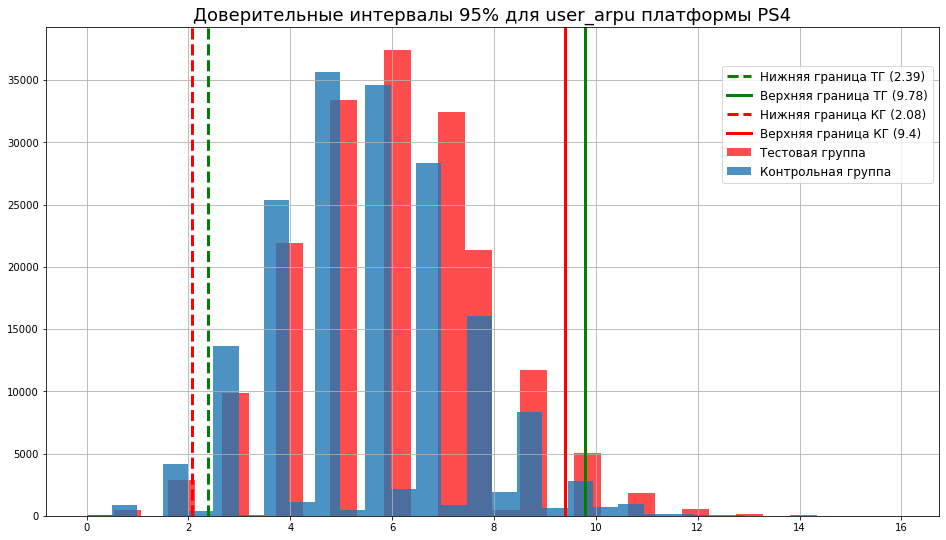

In [308]:
norm_confidence_plot(df_arpu_user,'user_arpu', 0.95, 'PS4')

**7.3. Доверительные интервалы ARPU для платформы XBox**

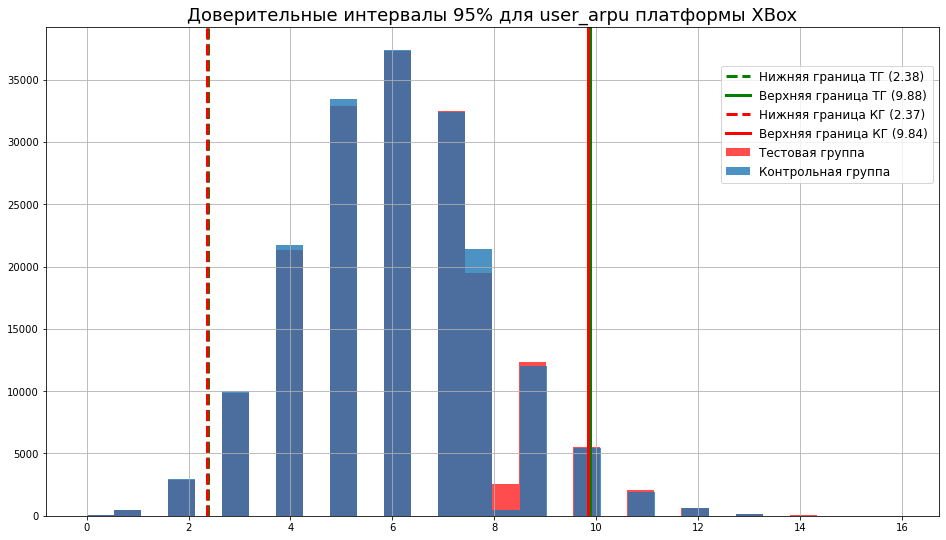

In [309]:
norm_confidence_plot(df_arpu_user,'user_arpu', 0.95, 'XBox')

**7.4. Доверительные интервалы ARRPU для платформы PC**

In [310]:
# создаем ДФ АRPPU каждого юзера без учета читеров для проверки статзначимости А/В теста.
df_arrpu_user = df_rpu_without_cheaters[df_rpu_without_cheaters['user_rpu'] != 0]
df_arrpu_user.rename(columns={'user_rpu' : 'user_arppu'}, inplace=True)

C:\Users\murzi\AppData\Local\Temp\ipykernel_16908\1141418723.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_arrpu_user.rename(columns={'user_rpu' : 'user_arppu'}, inplace=True)


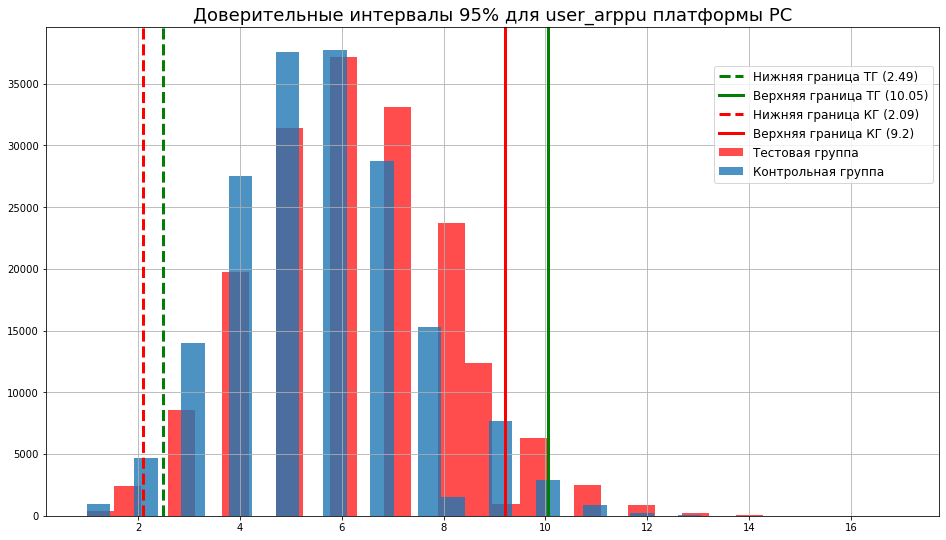

In [311]:
norm_confidence_plot(df_arrpu_user,'user_arppu', 0.95, 'PC')

**7.5. Доверительные интервалы ARPPU для платформы PS4**

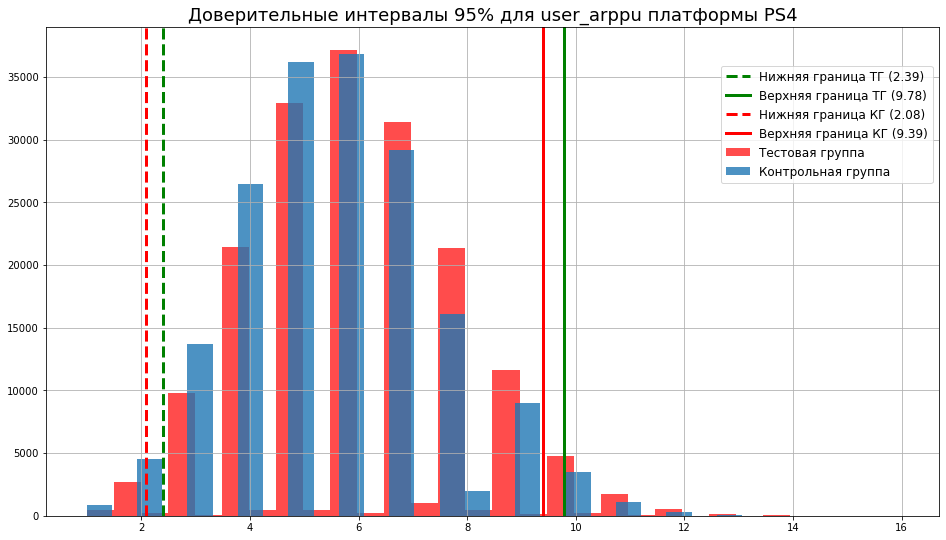

In [312]:
norm_confidence_plot(df_arrpu_user,'user_arppu', 0.95, 'PS4')

**7.6. Доверительные интервалы ARPPU для платформы XBox**

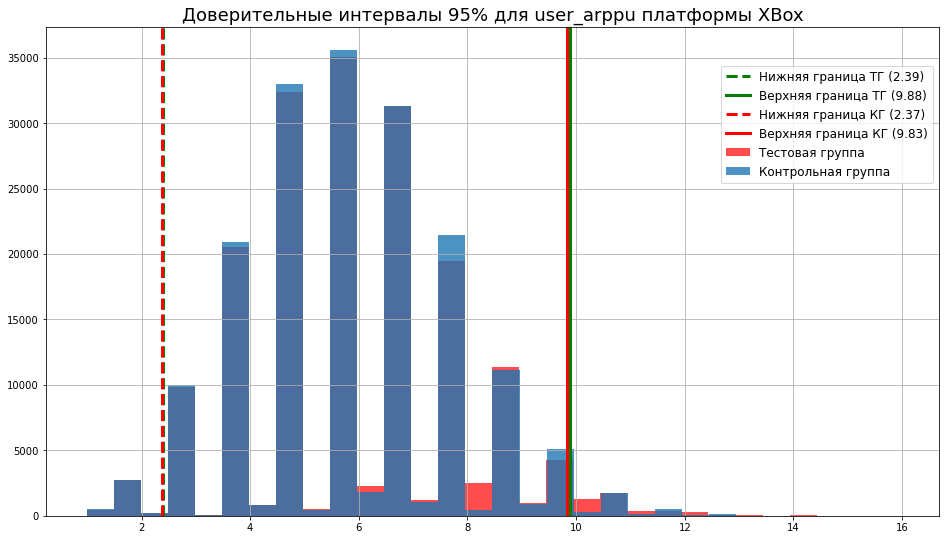

In [313]:
norm_confidence_plot(df_arrpu_user,'user_arppu', 0.95, 'XBox')

**7.7. Доверительные интервалы CASH для платформы PC**

In [314]:
# создаем ДФ CASH каждого юзера без учета читеров для проверки статзначимости А/В теста.
df_cash_user = df_total[(df_total['cheaters'] == 0) & 
                                    (df_total['cheaters_add'] == 0)].groupby(['user_id','platform','group'], as_index = False).agg(
    user_cash = pd.NamedAgg(column='cash', aggfunc='sum'))

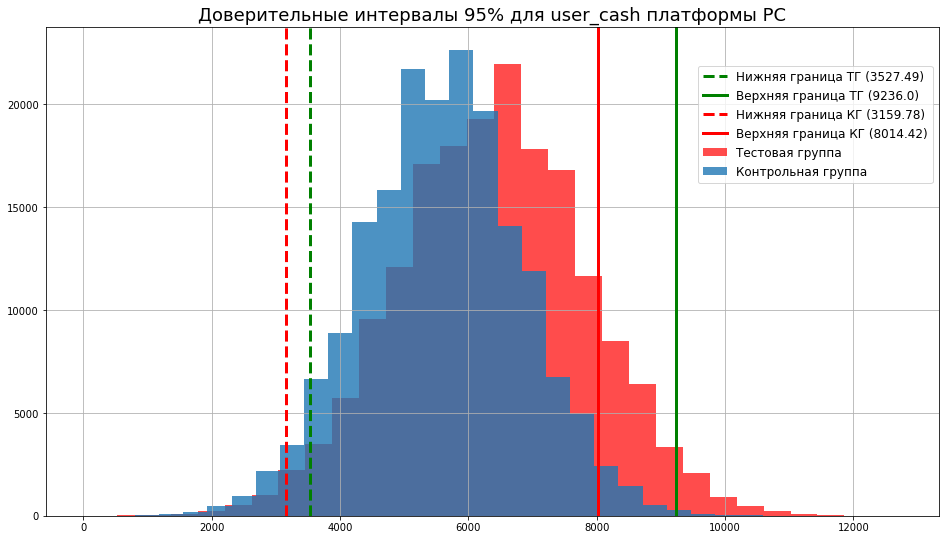

In [315]:
norm_confidence_plot(df_cash_user,'user_cash', 0.95, 'PC')

**7.8. Доверительные интервалы CASH для платформы PS4**

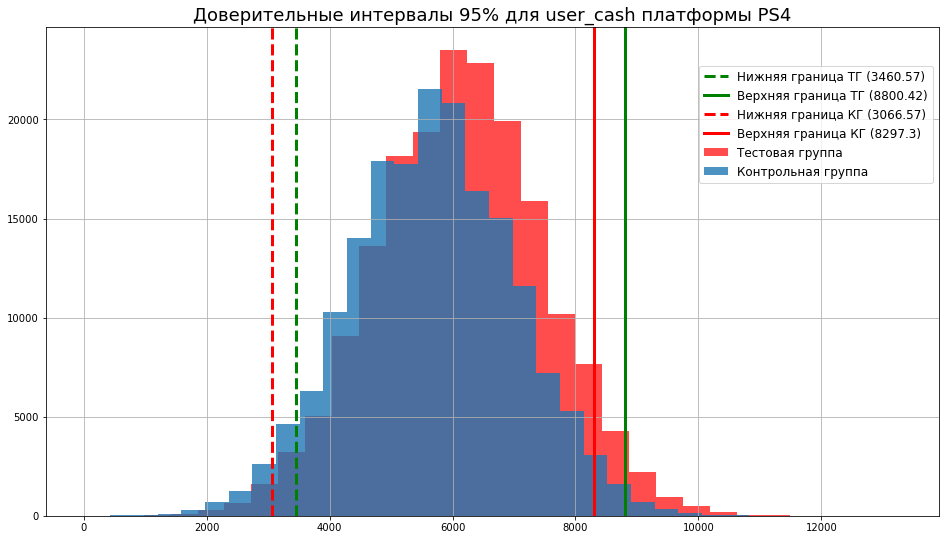

In [316]:
norm_confidence_plot(df_cash_user,'user_cash', 0.95, 'PS4')

**7.9. Доверительные интервалы CASH для платформы XBox**

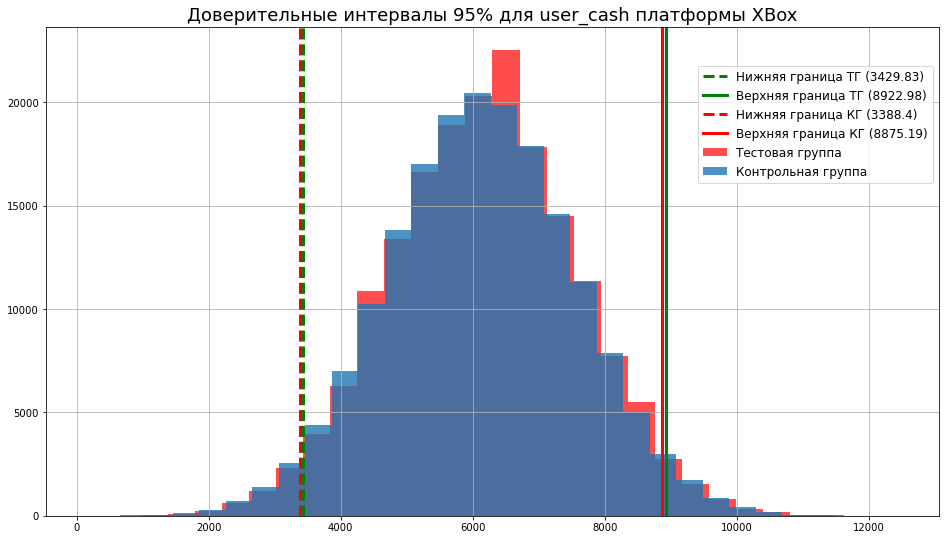

In [317]:
norm_confidence_plot(df_cash_user,'user_cash', 0.95, 'XBox')

**8. Сохранение данных для PowerBI**

In [333]:
df_arpu_daily.to_excel("/Users/murzi/Desktop/SKILLBOX/Финальная работа/Data/PowerBI_data/arpu_daily.xlsx")
df_arppu.to_excel("/Users/murzi/Desktop/SKILLBOX/Финальная работа/Data/PowerBI_data/df_arppu.xlsx")
df_arpu.to_excel("/Users/murzi/Desktop/SKILLBOX/Финальная работа/Data/PowerBI_data/df_arpu.xlsx")
df_spend_cash.to_excel("/Users/murzi/Desktop/SKILLBOX/Финальная работа/Data/PowerBI_data/df_spend_cash.xlsx")
df_pc.to_excel("/Users/murzi/Desktop/SKILLBOX/Финальная работа/Data/PowerBI_data/df_pc.xlsx")
df_ps4.to_excel("/Users/murzi/Desktop/SKILLBOX/Финальная работа/Data/PowerBI_data/df_ps4.xlsx")
df_xbox.to_excel("/Users/murzi/Desktop/SKILLBOX/Финальная работа/Data/PowerBI_data/df_xbox.xlsx")